# Sklearn教程

In [ ]:
#如果你还没有安装sklearn可以运行这行代码
!pip install sklearn

## 1.监督学习Supervised Learning
### 1.1 广义线性模型 Linear Model
主要讲述一些用于回归的方法，其中目标值 y 是输入变量 x 的线性组合。 数学概念表示为：如果 $\hat{y}$ 是预测值，那么有：
$$
\hat{y}(w, x) = w_0 + w_1 x_1 + ... + w_p x_p
$$

在整个模块中，我们定义向量 w = (w_1,..., w_p) 作为 coef_ ，定义 w_0 作为 intercept_ 


#### 1.1.1 普通最小二乘法 Ordinary Least Squares
`LinearRegression`拟合一个带有系数$w = (w_1, ..., w_p) $的线性模型，使数据集实际观测数据和预测数据（估计值）之间的残差平方和最小。其数学表达式为:
$$
\underset{w}{min\,} {|| X w - y||_2}^2
$$
LinearRegression 会调用`fit`方法来拟合数组 X， y，并且将线性模型的系数 `w`存储在其成员变量 coef_ 中:

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


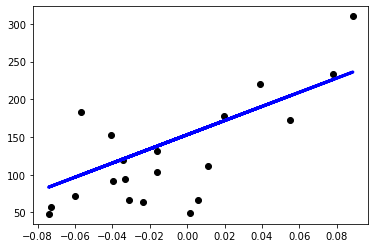

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#Load the diabeetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

#Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

#Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

#Split the target into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

#Create linear regression object
regr = linear_model.LinearRegression()

#Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

#make predictions using the testing sets
diabetes_y_pred = regr.predict(diabetes_X_test)

#The coefficients
print("Coefficients: \n", regr.coef_)
#The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
#The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

#Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks()
plt.yticks()

plt.show()

然而，对于普通最小二乘的系数估计问题，其依赖于模型各项的相互独立性。当各项是相关的，且设计矩阵 `X` 的各列近似线性相关，那么，设计矩阵会趋向于奇异矩阵，这种特性导致最小二乘估计对于随机误差非常敏感，可能产生很大的方差。例如，在没有实验设计的情况下收集到的数据，这种多重共线性（multicollinearity）的情况可能真的会出现。

**普通最小二乘法的复杂度**  
该方法使用X的奇异值分解来计算最小二乘解。如果X是一个形状为`(x_samples, n_features)`的矩阵，设$n_{sample}\geq_n{feature}$, 则该方法的复杂度为$O(n_{samples}n_{smaples}^2)$

### 1.1.2 岭回归
Rige回归通过对系数的大小施加惩罚来解决普通最小二乘法的一些问题。岭系数最小化的是带惩罚项的残差平方和，
$$
\underset{w}{min\,} {{|| X w - y||_2}^2 + \alpha {||w||_2}^2}
$$

其中，`α≥0`是控制系数收缩量的复杂性参数：α的值越大，收缩量越大，模型对共线性的鲁棒性也更强 

与其他线性模型一样，Ridge用`fit()`方法完成拟合，并将模型系数`ω`存储在其`coef_`成员中：

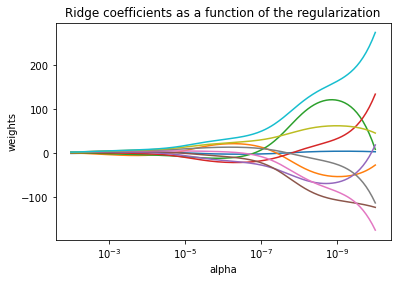

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

#X is the 10x10 Hilbert matrix
X = 1.0 / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

#Compute paths
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
#Display results
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis('tight')
plt.show()

**岭回归的复杂度**
与普通最小二乘法的复杂度是相同的

**设置正则化参数：广义交叉验证**  
`RidgeCV`通过内置的关于的alpha参数的交叉验证来实现岭回归。该对象与GridSearchCV的使用方式相同，只是它默认为Generalized Cross-Validation（广义交叉验证GCV），这是一种有效的留一验证方法（LOO-CV）：

In [6]:
from sklearn import linear_model
reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
reg.fit([[0, 0], [0, 0], [1, 1]], [0, .1, 1])
reg.alpha_

0.1

指定cv属性的值将触发（通过GridSearchCV的）的交叉验证。例如，cv=10将出发10折的交叉验证，而不是广义交叉验证（GCV）

### 1.1.3 Lasso
`Lasso`是拟合稀疏系统的线性模型。它在一些情况下是有用的，因为它倾向于使用较少参数值的情况，有效地减少给定解决方案所依赖变量的数量。因此，Lasso及其变体是压缩感知领域的基础。子啊一定条件下，它可以恢复一组非零权重的精确集。  
在数学公式表达上，它由一个带有` \ell_1 `先验的正则项的线性模型组成。其最小化的目标函数是：
$$
\underset{w}{min\,} { \frac{1}{2n_{samples}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}
$$
lasso estimate解决了加上罚项$ \alpha ||w||_1$的最小二乘法的最小化值，其中，α是一个常数，`||w||_1`是参数向量的`\ell_1`-norm范数   

`Lasso`类的实现使用了coordinate descent（坐标下降算法）来拟合系数。

Lasso(alpha=0.1)
r^2 on test data : 0.658064
ElasticNet(alpha=0.1, l1_ratio=0.7)
r^2 on test data : 0.642515


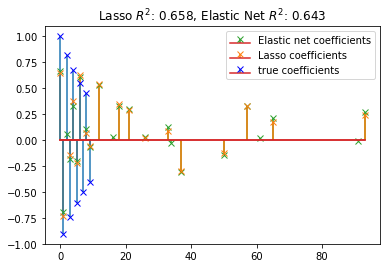

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

# #############################################################################
# Generate some sparse data to play with
np.random.seed(42)

n_samples, n_features = 50, 100
X = np.random.randn(n_samples, n_features)

# Decreasing coef w. alternated signs for visualization
idx = np.arange(n_features)
coef = (-1) ** idx * np.exp(-idx / 10)
coef[10:] = 0  # sparsify coef
y = np.dot(X, coef)

# Add noise
y += 0.01 * np.random.normal(size=n_samples)

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[: n_samples // 2], y[: n_samples // 2]
X_test, y_test = X[n_samples // 2 :], y[n_samples // 2 :]

# #############################################################################
# Lasso
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

# #############################################################################
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

m, s, _ = plt.stem(
    np.where(enet.coef_)[0],
    enet.coef_[enet.coef_ != 0],
    markerfmt="x",
    label="Elastic net coefficients",
    use_line_collection=True,
)
plt.setp([m, s], color="#2ca02c")
m, s, _ = plt.stem(
    np.where(lasso.coef_)[0],
    lasso.coef_[lasso.coef_ != 0],
    markerfmt="x",
    label="Lasso coefficients",
    use_line_collection=True,
)
plt.setp([m, s], color="#ff7f0e")
plt.stem(
    np.where(coef)[0],
    coef[coef != 0],
    label="true coefficients",
    markerfmt="bx",
    use_line_collection=True,
)

plt.legend(loc="best")
plt.title(
    "Lasso $R^2$: %.3f, Elastic Net $R^2$: %.3f" % (r2_score_lasso, r2_score_enet)
)
plt.show()

**设置正则化参数**  
`alpha`参数控制估计系数的稀疏度

- 使用交叉验证  
scikit-learn通过交叉验证来公开设置Lasso`alpha`参数的对象：`LassoCV`和`LassoLarsCV`。`LassoLarsCV`是基于下面将要提到的最小角回归算法。对于具有许多线性回归的高纬数据集，`LassoCV`最常见。然而，`LassoLarsCV`在寻找`alpha`参数值上更具有优势,而且如果样本数量比特征数量少得多时，通常`LassoLarsCV`比`LassoCV`要快。

<img src='../pics/reg-3.png' width='50%'>

<img src='../pics/reg-4.png' width='50%'>

- 基于信息标准的模型选择
有多种选择时，估计器`LassoLarsIC`建议使用Akaike information criterion(Akaike信息判断)（AIC）或Bayes Information criterion（贝叶斯信息判据）（BIC）。当使用f-fold交叉验证时，正则化路径只计算一次而不是k+1次，所以找到α的最优解值是一种计算上更经济的代替方法。然而，这种的判据需要对解决方案的自由度进行适当的估计，它会假设模型是正确的，对大样本（渐进结果）进行导出，即数据实际上是由该模型生成的。当问题严重受限（比样本更多的特征）时，它们也容易崩溃。
<img src='../pics/reg-5.png' width='50%'>

- 与SVM的正则化参数的比较
`alpha`和SVM的正则化参数`C`之间的等式关系是`alpha = 1 / C`或`alpha = 1 / (n_samples * C)`，并依赖于估计器和模型优化的确切的目标函数

### 1.1.4. 多任务Lasso
`MultiTaskLasso`是一个估计多元回归系数系数的线性模型：`y`是一个形状为`(n_samples, n_tasks)`的二维数组，其约束条件和其他回归问题（也称为任务）是一样的，都是所选的特征值。  
下图比较了通过简单的Lasso或MultiTaskLasso得到的W中非零的位置。Lasso估计产生分散的非零值，而MultiTaskLasso的一整列都是非零的。 

<img src='../pics/reg-6.png' width='50%'>
<img src='../pics/reg-7.png' width='50%'>

在数学上，它由一个线性模型组成，以混合的 \ell_1 \ell_2 作为正则化器进行训练。目标函数最小化是：
$$
\underset{w}{min\,} { \frac{1}{2n_{samples}} ||X W - Y||_{Fro} ^ 2 + \alpha ||W||_{21}}
$$
其中 Fro 表示 Frobenius 标准：
$$
||A||_{Fro} = \sqrt{\sum_{ij} a_{ij}^2}
$$
并且 $\ell_1 \ell_2$ 读取为:
$$
||A||_{2 1} = \sum_i \sqrt{\sum_j a_{ij}^2}
$$
`MultiTaskLasso` 类的实现使用了坐标下降作为拟合系数的算法。

### 1.1.5.弹性网络
`弹性网络`是一种使用L1，L2范数作为先验正则项训练的线性回归模型。这种组合允许拟合到一个只有少量参数是非零稀疏的模型，就像`Lasso`一样，但是它仍然保持了一些类似于`Ridge`的正则性质。我们可利用`l1_ratio`参数控制L1和L2的凸组合。

弹性网络在很多特征互相联系的情况下是非常有用的。Lasso很可能只随机考虑这些特征中的一个，而弹性网络更倾向于选择两个。  

在实践中，Lasso和Ridge之间权衡的一个优势是它允许在循环过程中(Under rotate)中继承Ridge的稳定性。  

在这里，最小化的目标函数是

$$
\underset{w}{min\,} { \frac{1}{2n_{samples}} ||X w - y||_2 ^ 2 + \alpha \rho ||w||_1 +\frac{\alpha(1-\rho)}{2} ||w||_2 ^ 2}
$$
`ElasticNetCV`类可以通过交叉验证来设置参数`alpha`(α)和`l1_ratio`(ρ)


### 1.1.6.多任务弹性网络
`MultiTaskElasticNet`是一个对多回归问题估算稀疏参数的弹性网络：`Y`是一个二维数组，形状是`(n_samples, n_tasks)`。其限制条件是和其他回归问题一样，是选择的特征，也称为tasks。  

从数学上来说，它包含一个混合的$\ell_1 \ell_2$先验和$\ell_2$先验为正则项训练的线性模型目标函数就是最小化：
$$
\underset{w}{min\,} {\frac {1}{2n_samples}} ||XW - Y||_Fro^2 + \alpha \rho ||W||_21 + \frac{\alpha(1-\rho)}{2} ||W||_Fro^2
$$

在`MultiTaskElasticNet`类中的实现采用了坐标下降法求解参数
在`MultiTaskElasticNetCV`中可以通过交叉验证来设置参数`alpha`(α)和`l1_ratio`(ρ)

### 1.1.7.最小角回归
最小角回归(LARS)是对高维数据的回归算法，由Bradley Efron，Trevor Hastie，Lain Johnstone和Robert Tibshirani开发完成。LARS和逐步回归很像。在每一步，它都寻找与响应最有关联的预测。当有很多预测有相同的关联时，它并不会继续利用相同的预测，而是在这些预测中找出应该等角的方向。

LARS的优点：
- 当 p >> n，该算法数值运算上非常有效。（例如当维度的数目远超点的个数）
- 它在计算上和前向选择一样快，和普通最小二乘法有相同的运算复杂度
- 如果两个变量对响应几乎有相等的联系，则它们的系数应该有相似的增长率。因此这个算法和我们直觉上的判断一样，而且还更加稳定。
- 它很容易修改并为其他估算器生成解，比如Lasso

LARS的缺点：
- 因为LARS是建立在循环拟合剩余变量上的，所以它对噪声非常敏感。

LARS模型可以在`Lars`，或者它的底层实现`lars_path`或`lars_path_gram`中被使用

### 1.1.8.LARS Lasso
`LassoLars`是一个LARS算法的lasso模型,不同于基于坐标下降法的实现，它可以得到一个精确解，也就是一个关于自身参数标准化的一个分段线性解

<img src='../pics/reg-8.png' width='50%'>


In [1]:
from sklearn import linear_model
reg = linear_model.LassoLars(alpha=.1)
reg.fit([[0, 0], [1, 1]], [0, 1])
reg.coef_

array([0.71715729, 0.        ])

Lars算法提供了一个几乎无代价的沿着正则化参数的系数的完整路径，因此常利用函数`lars_path`或`lars_path_gram`来取回路径

**数学表达式**  
该算法和逐步回归非常相似，但是它没有在每一步包含变量，它估计的参数是根据与其他剩余变量的联系来增加。  
在LARS的解中，没有给出一个向量的结果，而是给出了一条曲线，显示参数向量的L1范式的每个值的解。完全的参数路径存在`coef_path_`下。它的size是(n_samples, max_features+1)。其中第一列通常是全0列。 

### 1.1.9.正交匹配追踪法(OMP)
`OrthogonalMatchingPursuit`(正交匹配追踪法)和`orthogonal_map`使用了OMP算法近似拟合了一个带限制的线性模型，该限制影响于模型的非0系数（例：L0范数）

就像最小角回归一样，作为一个前向特征选择方法，正交匹配追踪法可以近似一个固定非0元素的最优向量解：
$$ 
\text{argmin} || y - X^2 \gamma||_2^2 \text {subject to} ||\gamma||_0 ≤ \leq n_{nonzero\_coefs} \\
$$

正交匹配追踪法也可以针对一个特殊的误差而不是一个特殊的非零系数的个数。可以表示为：
$$
\text{argmin} || \gamma||_0 \text{subject to} ||y - X \gamma||_2^2 ≤ \text{tol}   
$$

OMP是基于每一步的贪心算法，其每一步元素都是与当前残差高度相关的。它跟较为简单的匹配追踪(MP)很相似，但是比MP更好，在每一次迭代中，可以利用正交投影到之前选择的字典元素重新计算残差。 

### 1.1.10.贝叶斯回归
贝叶斯回归可以用在预估阶段的参数正则化：正则化参数的选择不是通过人为的选择，而是通过手动调节数据值来实现。 

上述过程可以通过引入无信息先验到模型中的超参数来完成。在`岭回归`中使用的$\ell_2$正则项相当于在$\omega$为高斯先验条件，且此先验的精确度为$\lambda ^{-1}$时，求最大后验估计。在这里，我们没有手工调参数lambda，而是让他作为一个变量，通过数据中估计得到。

为了得到一个全概率模型，输出$y$也被认为是关于$X\omega$的高斯分布

$$
p(y|X,w,\alpha) = \mathcal{N}(y|X, w, \alpha)
$$

Alpha在这里也是作为一个变量，通过数据中的估计得到。 

贝叶斯回归有如下几个优点：
- 它能根据已有的数据进行改变
- 它能在估计过程中引入正则项

贝叶斯回归有如下缺点：
- 它的推断过程是非常耗时的

**贝叶斯岭回归**  
`BayesianRidge`利用概率模型估算了上述的回归问题，其先验参数$\omega$是由以下球面高斯公式得出的：

$$
p(w|\lambda) = \mathcal{N}(w|0, \lambda^{-1}{I_{p}})
$$

先验参数$\alpha和\lambda$一般是服从gamma分布，这个分布与高斯成共轭先验关系。得到的模型一般称为**贝叶斯岭回归**，并且这个与传统的`Rideg`非常相似。

参数$\omega, \alpha和\lambda$是在模型拟合的时候一起被估算出来的，其中参数$\alpha和\lambda$通过最大似然估计得到。  
剩下的超参数$\alpha_1, \alpha_2, \lambda_1以及\lambda_2$是关于$\alpha和\lambda$的gamma分布的先验。它们通常被选择为**无信息先验**。默认$\alpha_1=\alpha_2=\lambda_1=\lambda_2=10^{-b}$

<img src='../pics/reg-9.png' width='50%'>


In [2]:
#用贝叶斯岭回归来解决回归问题
from sklearn import linear_model
X = [[0., 0.], [1., 1.], [2., 2.], [3., 3.]]
Y = [0., 1., 2., 3.]
reg = linear_model.BayesianRidge()
reg.fit(X, Y)

BayesianRidge()

In [3]:
#在模型训练完成后，可以用来预测新值
reg.predict([[1, 0.]])

array([0.50000013])

In [4]:
#权值可以这样访问
reg.coef_

array([0.49999993, 0.49999993])

**主动相关决策理论-ARD**  
`ARDRegression`（主动相关决策理论）和`Bayesian Ridge Regression`非常相似，但是会导致一个更加稀疏的权重。 
`ARDRegression`提出了一个不同的$\omega$的先验假设。具体来说，就是弱化了高斯分布为球形的假设。
它采用$\omega$分布是与轴平行的椭圆高斯分布。  
也就是说，每个权值$\omega_i$从一个中心在0点，精度为$\lambda_i$的高斯分布中采样得到的。 
$$
p(w|lambda) = \mathcal(w|0, A^{-1})
$$
并且$$\text {diag}(A) = \lambda = {{\lambda_1,..., \lambda_p}}$$

与`Bayesian Ridge Regression`不同，每个$\omega_i$都有一个标准差$\omega_i$。所有$\omega_i$的先验分布由超参数$\omega_1、\omega_2$确定的相同的gamma分布确定

<img src='../pics/reg-10.png' width='50%'>

ARD也被称为**稀疏贝叶斯学习**或**相关向量机**

### 1.1.11.logistic回归
logistic回归，虽然名字里有“回归”二字，但实际上是解决分类问题的一类线性模型。在某些文献中，logistic回归又被称为logit回归，maximunm-entropy classification（MaxEnt，最大熵分类），或log-linear classifier（对数线性分类器）。该模型利用函数logisitc function将单次实验（single trial）的可能结果输出为概率。 
scikit-learn中logistic回归在`LogisticRegression`类中实现二分类(binary)、一对多分类(one-vs-rest)及多项式logistic回归，并带有可选的L1和L2正则化。 
>注意，sklearn的逻辑回归在默认情况下使用L2正则化，这样的方式在机器学习领域是常见的，在统计分析领域是不常见的。正则化的另一优势是提升数值稳定性。sklearn通过将C设置为很大的值实现无正则化

作为优化问题，带L2罚项的二分类logistic回归要最小化以下代价函数(cost function):
$$
\underset{w, c}{min\,} \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .
$$
类似地，带 L1 正则的 logistic 回归解决的是如下优化问题：
$$
\underset{w, c}{min\,} \|w\|_1 + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .
$$
Elastic-Net正则化是L1 和 L2的组合，来使如下代价函数最小:
$$
\min_{w, c} \frac{1 - \rho}{2}w^T w + \rho \|w\|_1 + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .
$$
其中ρ控制正则化L1与正则化L2的强度(对应于`l1_ratio`参数)。

注意，在这个表示法中，假定目标y_i在测试时应属于集合[-1,1]。我们可以发现Elastic-Net在ρ=1时与L1罚项等价,在ρ=0时与L2罚项等价

在 `LogisticRegression` 类中实现了这些优化算法: `liblinear`， `newton-cg`， `lbfgs`， `sag` 和 `saga`。

`liblinear`应用了坐标下降算法（Coordinate Descent, CD），并基于 scikit-learn 内附的高性能 C++ 库 LIBLINEAR library 实现。不过 CD 算法训练的模型不是真正意义上的多分类模型，而是基于 “one-vs-rest” 思想分解了这个优化问题，为每个类别都训练了一个二元分类器。因为实现在底层使用该求解器的 `LogisticRegression` 实例对象表面上看是一个多元分类器。 `sklearn.svm.l1_min_c` 可以计算使用 L1时 C 的下界，以避免模型为空（即全部特征分量的权重为零）。

`lbfgs`, `sag` 和 `newton-cg` 求解器只支持 L2罚项以及无罚项，对某些高维数据收敛更快。这些求解器的参数 `multi_class`设为 `multinomial` 即可训练一个真正的多项式 logistic 回归 [5] ，其预测的概率比默认的 `“one-vs-rest” `设定更为准确。

`sag` 求解器基于平均随机梯度下降算法（Stochastic Average Gradient descent） [6]。在大数据集上的表现更快，大数据集指样本量大且特征数多。

`saga` 求解器 [7] 是 `sag` 的一类变体，它支持非平滑（non-smooth）的 L1 正则选项 `penalty="l1"` 。因此对于稀疏多项式 logistic 回归 ，往往选用该求解器。`saga`求解器是唯一支持弹性网络正则选项的求解器。

`lbfgs`是一种近似于Broyden–Fletcher–Goldfarb–Shanno算法[8]的优化算法，属于准牛顿法。lbfgs求解器推荐用于较小的数据集，对于较大的数据集，它的性能会受到影响。[9]

总的来说，各求解器特点如下:

|罚项|`liblinear`|`lbfgs`|`newton-cg`|`sag`|`saga`|
|--|--|--|--|--|--|
|多项式损失+L2罚项|✕|✓|✓|✓|✓|
|一对剩余（One vs Rest）+L2罚项|✓|✓|✓|✓|✓|
|多项式损失+L1罚项|✕|✕|✕|✕|✓|
|一对剩余（One vs Rest）+L1罚项|✓|✕|✕|✕|✓|
|弹性网络|✕|✕|✕|✕|✓|
|无罚项|✕|✓|✓|✓|✓|
|表现|||||
|惩罚偏置值(差)|✓|✕|✕|✕|✕|
|大数据集上速度快|✕|✕|✕|✓|✓|
|未缩放数据集上鲁棒|✓|✓|✓|✕|✕|

默认情况下，`lbfgs`求解器鲁棒性占优。对于大数据集，`saga`求解器通常更快。对于大数据集，还可以用`SGDClassifier`,并使用对数损失(`log` loss)这可能更快，但需要更多调优。

### 1.1.12.随机梯度下降，SGD
随机梯度下降是拟合线性模型的一个简单而高效的方法。在样本量（和特征数）很大时尤为有用。 方法`partial_fit`可用于online learning（在线学习）或基于out-of-core learning（外存的学习）  
`SGDClassifier`和`SGDRegressor`分别用于拟合分类问题和回归问题的线性模型，可使用不同的（凸）损失函数，支持不同的罚项。例如，设定`loss="dog"`，则`SGDClassifier`拟合一个逻辑斯蒂回归模型，而`loss="hinge"`拟合线性支持向量机（SVM）


### 1.1.13.Perceptron（感知器）
`Perceptron`是适用于大规模学习的一种简单算法。默认情况下：
- 不需要设置学习率(learning rate)
- 不需要正则化处理
- 仅使用错误样本更新模型

最后一点表明使用合页损失(hinge loss)的感知机比SGD略快，所得模型更稀疏

### 1.1.14.Passive Aggressive Algorithms（被动攻击算法
被动攻击算法是大规模学习的一类算法。和感知机类似，也不需要设置学习率，不过比感知机多一个正则化参数`C`。  
对于分类问题，`PassiveAggressiveClassifier`可设定`loss="hinge"`(PA-I)或`loss="squared_hinge"`(PA-II)。对于回归问题，`PassiveAggressiveRegressor`可设置`loss="epsilon_insenstive"`(PA-I)或`loss="squared_epsilon_insensitive"`(PA-II)


### 1.1.15.稳健回归（Robustness Regression）：处理离群点(outliers)和模型错误
稳健回归（robust regression）特别适用于回归模型包含损坏数据(corrupt data)的情况，如离群点或模型中的错误。

<img src='../pics/reg-11.png' width='50%'>

**各种使用场景与相关概念**  
处理包含离群点的数据时牢记以下几点： 
- 离群值在x上还是y方向上？
    - 离群值在y方向上
    <img src='../pics/reg-12.png' width='50%'>
    
    - 离群值在x方向上
    <img src='../pics/reg-13.png' width='50%'>
    
- 离群点的比例vs.错误的量级(amplitude)  
    离群点的数量很重要，离群程度也同样重要
    - 低离群点的数量
    <img src='../pics/reg-14.png' width='50%'>
    - 高离群点的数量
    <img src='../pics/reg-15.png' width='50%'>

稳健拟合（robust fitting）的一个重要概念是崩溃点（breakdown point），即拟合模型（仍准确预测）所能承受的离群值最大比例。 
注意，在高纬数据条件下(`n_samples`大)，一般而言很难完成稳健拟合，很可能完全不起作用

>寻找平衡： 预测器的选择
>- Scikit-learn提供了三种稳健回归的预测器（estimator）: RANSAC ， Theil Sen 和 HuberRegressor
>- HuberRegressor 一般快于 RANSAC 和 Theil Sen ，除非样本数很大，即 n_samples >> n_features 。 这是因为 RANSAC 和 Theil Sen 都是基于数据的较小子集进行拟合。但使用默认参数时， Theil Sen 和 RANSAC 可能不如 HuberRegressor 鲁棒。
>- RANSAC 比 Theil Sen 更快，在样本数量上的伸缩性（适应性）更好。
>- RANSAC 能更好地处理y方向的大值离群点（通常情况下）。
>- Theil Sen 能更好地处理x方向中等大小的离群点，但在高维情况下无法保证这一特点。 实在决定不了的话，请使用 RANSAC

**RANSAC：随机抽样一致性算法(RANdom SAmple Consensus)**
随机抽样一致性算法(RANdom SAmple Consensus)利用全体数据中局内点(inliers)的一个随机子集拟合模型。
RANSAC是一种非确定性算法，以一定概率输出一个可能的合理结果，依赖于迭代次数(参数`max_trials`)。这种算法主要解决线性或非线性回归问题，在计算机视觉摄影测绘领域尤为流行。 
算法从全体样本中分出一个局内点集合，全体样本可能由于测量错误或对数据的假设而含有噪点、离群点。最终的模型仅从这个局内点集合中得出。

<img src='../pics/reg-15.png' width='50%'>

- 算法细节
    - 1.从原始数据中抽样`min_samples`数量的随机样本，检查数据是否合法（见`is_data_valid`)
    - 2.用一个随机子集拟合模型(`base_estimator.fit`).检查模型是否合法（见`is_model_valid`)
    - 3.计算预测模型的残差（residual），将全体数据分成局内点和离群点(`base_estimator.predict(X) - y`).绝对残差小于`residual_threshold`的全体数据认为是局内点。
    - 4.若局内点样本数最大，保存当前模型为最佳模型。以免当前模型离群点数量恰好相等（而出现未定义情况），规定仅当数值大于当前最值时认为是最佳模型。
    
上述步骤或者迭代到最大次数(`max_trials`),或者某些终止条件满足时停下（见`stop_n_inliers`和`stop_score`)。最终模型由之前确定的最佳模型的局内点样本（一致性集合，consensus set）预测。

函数`is_data_valid`和`is_model_valid`可以识别出随机样本子集中的退化组合(degenreate combinations)并予以丢弃(reject)。即便不需要考虑退化情况，也会使用`is_data_valid`，因为在拟合模型之前调用它能得到更高的计算性能


**Theil-Sen预估器：广义中值估计器（generalized-median-based estimator）**
`TheilSenRegressor`估计器：使用中位数在多个维度泛化，对多元异常值更具有鲁棒性，但问题是，随着维数的增加，估计器的准确性在迅速下降。准确性的丢失，导致在高纬上的估计值比不上普通的最小二乘法
